In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p /content/drive/MyDrive/ML/VOCdevkit
!tar -xf /content/drive/MyDrive/ML/VOCtrainval_06-Nov-2007.tar -C /content/drive/MyDrive/ML/


In [ ]:
import os
import torch
from PIL import Image
import xml.etree.ElementTree as ET
from torchvision.transforms import functional as F

# VOC classes
VOC_CLASSES = [
    "__background__",
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair",
    "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"
]

class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "JPEGImages")))
        self.anns = sorted(os.listdir(os.path.join(root, "Annotations")))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "JPEGImages", self.imgs[idx])
        ann_path = os.path.join(self.root, "Annotations", self.anns[idx])
        img = Image.open(img_path).convert("RGB")

        tree = ET.parse(ann_path)
        boxes = []
        labels = []

        for obj in tree.findall("object"):
            name = obj.find("name").text
            label = VOC_CLASSES.index(name)
            bndbox = obj.find("bndbox")
            xmin = int(float(bndbox.find("xmin").text))
            ymin = int(float(bndbox.find("ymin").text))
            xmax = int(float(bndbox.find("xmax").text))
            ymax = int(float(bndbox.find("ymax").text))
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms:
            img = self.transforms(img)
        else:
            img = F.to_tensor(img)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [ ]:
import torchvision

from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Transform function
def get_transform():
    return torchvision.transforms.Compose([F.to_tensor])

# Load dataset
dataset = VOCDataset("/content/drive/MyDrive/ML/VOCdevkit/VOC2007", get_transform())
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Create model
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=len(VOC_CLASSES))
model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
!pip install torch torchvision matplotlib

!pip install tqdm
from tqdm.notebook import tqdm


In [ ]:
# ✅ Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 5

# ✅ Training loop with tqdm
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"✅ Epoch [{epoch+1}/{num_epochs}] ➤ Total Loss: {epoch_loss:.4f}")
    for k, v in loss_dict.items():
        print(f"   🔹 {k}: {v.item():.4f}")

# ✅ Save model to Drive
save_path = "/content/drive/MyDrive/ML/fasterrcnn_voc2007.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Model saved to {save_path}")


Epoch 1/5:   0%|          | 0/2506 [00:00<?, ?it/s]

✅ Epoch [1/5] ➤ Total Loss: 1107.5040
   🔹 loss_classifier: 0.3330
   🔹 loss_box_reg: 0.1767
   🔹 loss_objectness: 0.0179
   🔹 loss_rpn_box_reg: 0.0110


Epoch 2/5:   0%|          | 0/2506 [00:00<?, ?it/s]

✅ Epoch [2/5] ➤ Total Loss: 891.9874
   🔹 loss_classifier: 0.1141
   🔹 loss_box_reg: 0.1291
   🔹 loss_objectness: 0.0015
   🔹 loss_rpn_box_reg: 0.0545


Epoch 3/5:   0%|          | 0/2506 [00:00<?, ?it/s]

✅ Epoch [3/5] ➤ Total Loss: 801.5280
   🔹 loss_classifier: 0.0755
   🔹 loss_box_reg: 0.1373
   🔹 loss_objectness: 0.0015
   🔹 loss_rpn_box_reg: 0.0086


Epoch 4/5:   0%|          | 0/2506 [00:00<?, ?it/s]

✅ Epoch [4/5] ➤ Total Loss: 763.6587
   🔹 loss_classifier: 0.2077
   🔹 loss_box_reg: 0.3355
   🔹 loss_objectness: 0.0080
   🔹 loss_rpn_box_reg: 0.0074


Epoch 5/5:   0%|          | 0/2506 [00:00<?, ?it/s]

✅ Epoch [5/5] ➤ Total Loss: 751.5129
   🔹 loss_classifier: 0.1377
   🔹 loss_box_reg: 0.1547
   🔹 loss_objectness: 0.0114
   🔹 loss_rpn_box_reg: 0.0144
✅ Model saved to /content/drive/MyDrive/ML/fasterrcnn_voc2007.pth


In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Classes used for Pascal VOC
VOC_CLASSES = [
    "__background__", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"
]

# 🔁 Load model
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)  # pretrained=False since we're loading our own weights
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=len(VOC_CLASSES))
model.load_state_dict(torch.load("/content/drive/MyDrive/ML/fasterrcnn_voc2007.pth", map_location=device))
model.to(device)
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

🔍 Running inference on: 001337.jpg


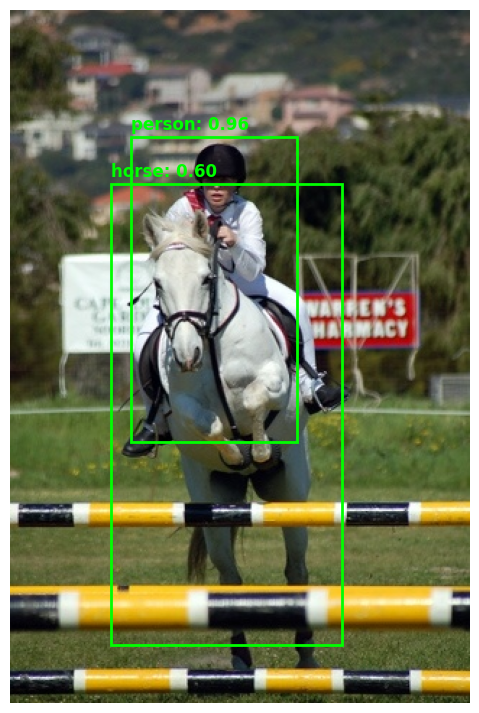

In [ ]:
import os
import random
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 🔹 VOC 2007 Classes
VOC_CLASSES = [
    "__background__", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"
]

# 🔹 Load trained model
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=len(VOC_CLASSES))
model.load_state_dict(torch.load("/content/drive/MyDrive/ML/fasterrcnn_voc2007.pth", map_location=device))
model.to(device)
model.eval()

# 🔹 Pick a random VOC image
voc_images_dir = "/content/drive/MyDrive/ML/VOCdevkit/VOC2007/JPEGImages"
random_image = random.choice(os.listdir(voc_images_dir))
image_path = os.path.join(voc_images_dir, random_image)
print(f"🔍 Running inference on: {random_image}")

# 🔹 Draw predictions
def predict_and_plot(img_path, model, device, threshold=0.5):
    image = Image.open(img_path).convert("RGB")
    img_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)[0]

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for box, label, score in zip(outputs['boxes'], outputs['labels'], outputs['scores']):
        if score >= threshold:
            x1, y1, x2, y2 = box.cpu().numpy()
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f"{VOC_CLASSES[label.item()]}: {score.item():.2f}",
                    color='lime', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

# 🔹 Run prediction
predict_and_plot(image_path, model, device)


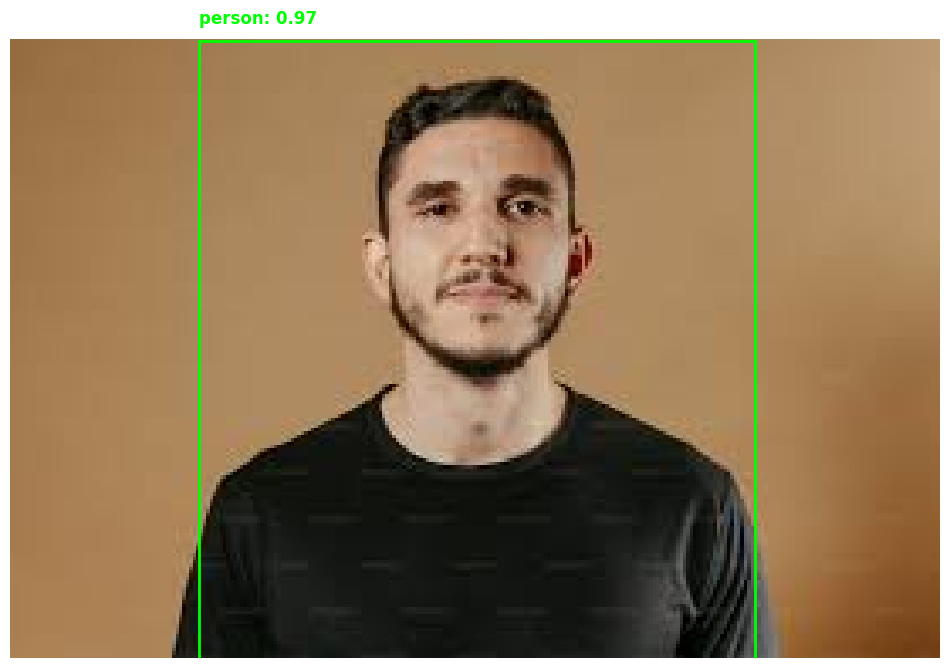

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 🔹 VOC 2007 Classes
VOC_CLASSES = [
    "__background__", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"
]

# 🔹 Load your trained model
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=len(VOC_CLASSES))
model.load_state_dict(torch.load("/content/drive/MyDrive/ML/fasterrcnn_voc2007.pth", map_location=device))
model.to(device)
model.eval()

# 🔹 Path to your custom image
custom_image_path = "/content/drive/MyDrive/ML/MLtest1.jpg"  # ⬅️ Change filename if needed

# 🔹 Inference and visualization
def predict_and_plot(img_path, model, device, threshold=0.5):
    image = Image.open(img_path).convert("RGB")
    img_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)[0]

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for box, label, score in zip(outputs['boxes'], outputs['labels'], outputs['scores']):
        if score >= threshold:
            x1, y1, x2, y2 = box.cpu().numpy()
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f"{VOC_CLASSES[label.item()]}: {score.item():.2f}",
                    color='lime', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

# 🔹 Run prediction on custom image
predict_and_plot(custom_image_path, model, device)


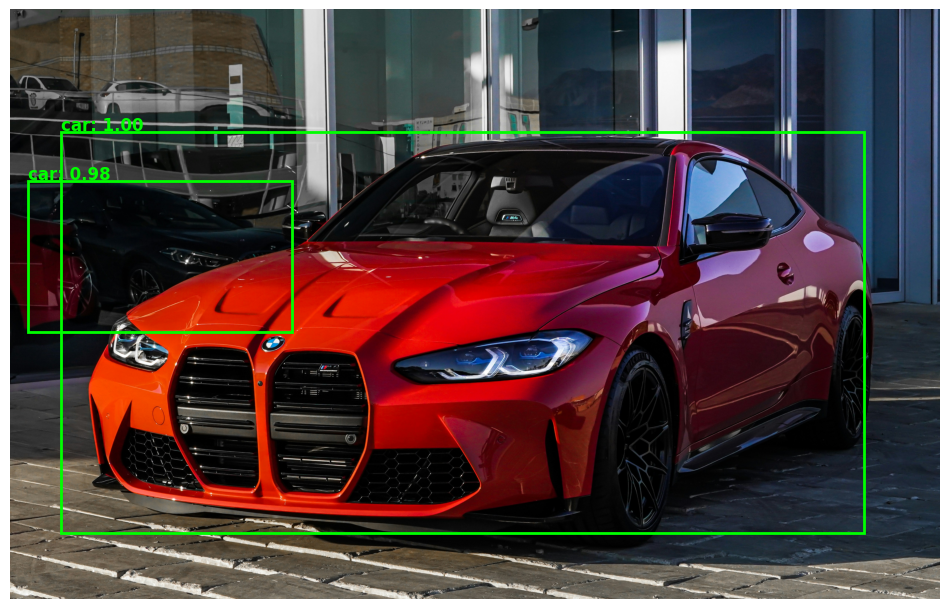

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 🔹 VOC 2007 Classes
VOC_CLASSES = [
    "__background__", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"
]

# 🔹 Load your trained model
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=len(VOC_CLASSES))
model.load_state_dict(torch.load("/content/drive/MyDrive/ML/fasterrcnn_voc2007.pth", map_location=device))
model.to(device)
model.eval()

# 🔹 Path to your custom image
custom_image_path = "/content/drive/MyDrive/ML/MLtest3.jpg"  # ⬅️ Change filename if needed

# 🔹 Inference and visualization
def predict_and_plot(img_path, model, device, threshold=0.5):
    image = Image.open(img_path).convert("RGB")
    img_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)[0]

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for box, label, score in zip(outputs['boxes'], outputs['labels'], outputs['scores']):
        if score >= threshold:
            x1, y1, x2, y2 = box.cpu().numpy()
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f"{VOC_CLASSES[label.item()]}: {score.item():.2f}",
                    color='lime', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

# 🔹 Run prediction on custom image
predict_and_plot(custom_image_path, model, device)


In [ ]:
# ✅ Clone the official torchvision repo (if not already)
!git clone https://github.com/pytorch/vision.git


Cloning into 'vision'...
remote: Enumerating objects: 662584, done.
remote: Counting objects: 100% (1475/1475), done.
remote: Compressing objects: 100% (1181/1181), done.
remote: Total 662584 (delta 1159), reused 358 (delta 290), pack-reused 661109 (from 3)
Receiving objects: 100% (662584/662584), 1.19 GiB | 16.99 MiB/s, done.
Resolving deltas: 100% (620011/620011), done.


In [ ]:
# ✅ 1. Create required directory
!mkdir -p /content/drive/MyDrive/ML/VOCdevkit/VOC2007/ImageSets/Main

# ✅ 2. Create val.txt using 500 random image filenames (without .jpg)
!ls /content/drive/MyDrive/ML/VOCdevkit/VOC2007/JPEGImages | \
  grep ".jpg" | sed 's/.jpg//' | shuf | head -n 500 > \
  /content/drive/MyDrive/ML/VOCdevkit/VOC2007/ImageSets/Main/val.txt


In [ ]:
!head -n 5 /content/drive/MyDrive/ML/VOCdevkit/VOC2007/ImageSets/Main/val.txt


000917
003355
007234
000962
009620


In [ ]:
import sys
sys.path.append("/content/vision/references/detection")


In [ ]:
from engine import evaluate


In [ ]:
print(evaluate)


<function evaluate at 0x7b4ca78944a0>


In [ ]:
!mkdir -p /content/drive/MyDrive/ML/VOCdevkit/VOC2007/ImageSets/Main

!ls /content/drive/MyDrive/ML/VOCdevkit/VOC2007/JPEGImages | \
  grep ".jpg" | sed 's/.jpg//' | shuf | head -n 500 > \
  /content/drive/MyDrive/ML/VOCdevkit/VOC2007/ImageSets/Main/val.txt


In [ ]:
!ls /content/drive/MyDrive/ML/VOCdevkit/VOC2007/ImageSets/Main/val.txt


/content/drive/MyDrive/ML/VOCdevkit/VOC2007/ImageSets/Main/val.txt


In [ ]:
# Check VOC2007 exists
!ls /content/drive/MyDrive/ML/VOCdevkit/

# Check required folders inside VOC2007
!ls /content/drive/MyDrive/ML/VOCdevkit/VOC2007/

# Check val.txt exists
!head /content/drive/MyDrive/ML/VOCdevkit/VOC2007/ImageSets/Main/val.txt

# Check one of those images exists
!ls /content/drive/MyDrive/ML/VOCdevkit/VOC2007/JPEGImages/008252.jpg


VOC2007
Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject
008252
000256
007376
002518
009318
003717
000902
000289
002984
000162
/content/drive/MyDrive/ML/VOCdevkit/VOC2007/JPEGImages/008252.jpg


In [ ]:
!ls /content/drive/MyDrive/ML/VOCdevkit/VOC2007/Annotations/008252.xml


/content/drive/MyDrive/ML/VOCdevkit/VOC2007/Annotations/008252.xml


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from xml.etree import ElementTree as ET
import torchvision.transforms as T
from engine import evaluate

# All VOC 20 classes
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

# Custom Dataset Class for VOC2007 with COCO-compatible targets
class VOCDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "JPEGImages")))
        self.annots = sorted(os.listdir(os.path.join(root, "Annotations")))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "JPEGImages", self.imgs[idx])
        annot_path = os.path.join(self.root, "Annotations", self.annots[idx])
        img = Image.open(img_path).convert("RGB")

        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            name = obj.find("name").text.lower().strip()
            if name in VOC_CLASSES:
                label_id = VOC_CLASSES.index(name)
                labels.append(label_id)

                bbox = obj.find("bndbox")
                b = [int(float(bbox.find(tag).text)) for tag in ["xmin", "ymin", "xmax", "ymax"]]
                boxes.append(b)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        image_id = int(os.path.splitext(self.imgs[idx])[0])  # ✅ Fixed for COCO

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,  # ✅ INT (not tensor)
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Define basic ToTensor transform
def get_transform():
    return T.Compose([T.ToTensor()])

# Load dataset
val_dataset = VOCDataset(
    root="/content/drive/MyDrive/ML/VOCdevkit/VOC2007",
    transforms=get_transform()
)

# DataLoader
val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)

# Set device and model to eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Run mAP evaluation
evaluate(model, val_loader, device=device)


creating index...
index created!
Test:  [   0/1253]  eta: 0:11:21  model_time: 0.4831 (0.4831)  evaluator_time: 0.0083 (0.0083)  time: 0.5438  data: 0.0499  max mem: 4303
Test:  [ 100/1253]  eta: 0:11:29  model_time: 0.5714 (0.5505)  evaluator_time: 0.0073 (0.0078)  time: 0.6382  data: 0.0362  max mem: 4303
Test:  [ 200/1253]  eta: 0:10:25  model_time: 0.4843 (0.5458)  evaluator_time: 0.0067 (0.0092)  time: 0.5667  data: 0.0366  max mem: 4303
Test:  [ 300/1253]  eta: 0:09:31  model_time: 0.6028 (0.5515)  evaluator_time: 0.0068 (0.0086)  time: 0.6170  data: 0.0364  max mem: 4303
Test:  [ 400/1253]  eta: 0:08:31  model_time: 0.4814 (0.5521)  evaluator_time: 0.0067 (0.0084)  time: 0.5869  data: 0.0373  max mem: 4303
Test:  [ 500/1253]  eta: 0:07:34  model_time: 0.6027 (0.5553)  evaluator_time: 0.0071 (0.0087)  time: 0.6438  data: 0.0365  max mem: 4303
Test:  [ 600/1253]  eta: 0:06:35  model_time: 0.5764 (0.5570)  evaluator_time: 0.0072 (0.0086)  time: 0.6292  data: 0.0374  max mem: 4303
T